<font size="+3"><strong>5.5. Bankruptcy in Taiwan 🇹🇼</strong></font>

Congratulations on reaching the final assignment!

You’ve learned how to build and evaluate models for bankruptcy prediction—now it’s time to put it all into practice using Taiwan company data.

In this assignment, you'll follow a full ML workflow  to Predict Bankruptcy in Taiwan.

In [46]:
# Import libraries 
import gzip
import json
import pickle

import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# Prepare Data

## Import

**Task 5.5.1** Load the contents of the "taiwan-bankruptcy-data.json.gz" and assign it to the variable taiwan_data

Note that taiwan_data should be a dictionary. You'll create a DataFrame in a later task.

In [2]:
# Load data file
with gzip.open("data/taiwan-bankruptcy-data.json.gz", "r") as f:
    taiwan_data = json.load(f)

print(type(taiwan_data))

<class 'dict'>


**Task 5.5.2** Now extract the key names from taiwan_data and assign them to the variable taiwan_data_keys.

In [3]:
taiwan_data_keys = taiwan_data.keys()
print(taiwan_data_keys)

dict_keys(['schema', 'observations', 'metadata'])


**Task 5.5.3** Calculate how many companies are in taiwan_data and assign the result to n_companies. Then Check Activity to verify your results.

In [4]:
n_companies = len(taiwan_data["observations"])
print(n_companies)

6137


**Task 5.5.4** Calculate the number of features associated with each company and assign the result to n_features. Check Activity to verify your results.

In [5]:
n_features = len(taiwan_data["observations"][0])  
print(n_features)

97


**Task 5.5.5** Create a function named wrangle that takes the path to a compressed JSON file (in .gz format) as input. The function should read and parse the file, extract the data under the "observations" key, and return it as a pandas DataFrame.

In [6]:
# Create wrangle function
def wrangle(filename):
    
    # unzip and load the json file
    with gzip.open(filename) as f:
        data = json.load(f)

    # read the data to dataframe
    df = pd.DataFrame().from_dict(data["observations"]).set_index("id")

    return df


In [7]:
df = wrangle("data/taiwan-bankruptcy-data.json.gz")  
print("df shape:", df.shape)
df.head()

df shape: (6137, 96)


,bankrupt,Attr_1,Attr_2,Attr_3,Attr_4,Attr_5,Attr_6,Attr_7,Attr_8,Attr_9,...,Attr_86,Attr_87,Attr_88,Attr_89,Attr_90,Attr_91,Attr_92,Attr_93,Attr_94,Attr_95
id,,,,,,,,,,,,,,,,,,,,,
1,True,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
2,True,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
3,True,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
4,True,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
5,True,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


## Explore

**Task 5.5.6** Is there any missing data in the dataset? Create a Series where the index contains the name of the columns in df and the values are the number of NaNs in each column.

In [8]:
nans_by_col = df.isna().sum()
print("nans_by_col shape:", nans_by_col.shape)
nans_by_col.head()

nans_by_col shape: (96,)


bankrupt    0
Attr_1      0
Attr_2      0
Attr_3      0
Attr_4      0
dtype: int64

**Task 5.5.7** Is the data imbalanced? Create a bar chart that shows the normalized value counts for the column df["bankrupt"]. Use fig, ax = plt.subplots() to define the plot. Add title and label your axes. 

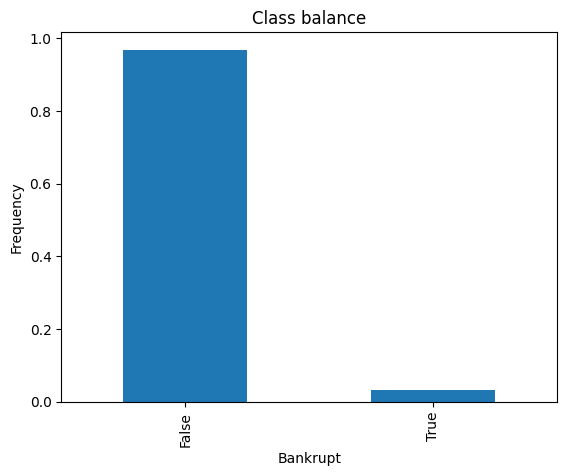

In [9]:
# Plot class balance
fig, ax = plt.subplots()
df["bankrupt"].value_counts(normalize=True).plot(kind="bar", 
                                                 xlabel="Bankrupt",
                                                 ylabel="Frequency",
                                                 title="Class balance",
                                                 ax=ax);

## Split

**Task 5.5.8** Create a feature matrix X and a target vector y , using the target column bankrupt.

In [10]:
target = "bankrupt"
X = df.drop(columns=target)
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (6137, 95)
y shape: (6137,)


**Task 5.5.9** Divide your dataset into training and test sets using a randomized split. Your test set should be 20% of your data. Keep random_state to 42.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4909, 95)
y_train shape: (4909,)
X_test shape: (1228, 95)
y_test shape: (1228,)


## Resample

**Task 5.5.10** Create a new feature matrix X_train_over and target vector y_train_over by performing random over-sampling on the training data. Keep the random_state to 42.

In [12]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (9506, 95)


,Attr_1,Attr_2,Attr_3,Attr_4,Attr_5,Attr_6,Attr_7,Attr_8,Attr_9,Attr_10,...,Attr_86,Attr_87,Attr_88,Attr_89,Attr_90,Attr_91,Attr_92,Attr_93,Attr_94,Attr_95
0,0.506167,0.568360,0.553563,0.595158,0.595187,0.998984,0.797402,0.809323,0.303514,0.781581,...,0.811337,0.001729,0.623492,0.595156,0.841980,0.286225,0.026981,0.565927,1,0.018617
1,0.468678,0.497928,0.521548,0.587714,0.587714,0.998757,0.797179,0.809117,0.303599,0.781363,...,0.774070,0.006710,0.624140,0.587714,0.838442,0.278596,0.026640,0.564319,1,0.034963
2,0.543265,0.589730,0.602923,0.611049,0.611049,0.999169,0.797580,0.809493,0.303438,0.781776,...,0.818833,0.004115,0.624494,0.611049,0.842961,0.286459,0.026950,0.565816,1,0.018451
3,0.494759,0.557948,0.541571,0.597666,0.597666,0.998992,0.797439,0.809350,0.303564,0.781611,...,0.811436,0.002108,0.623788,0.597663,0.841389,0.280616,0.026833,0.565351,1,0.026543
4,0.529177,0.600360,0.584346,0.603843,0.603713,0.999014,0.797568,0.809475,0.303743,0.781746,...,0.834857,0.009962,0.623576,0.603844,0.842959,0.278878,0.026799,0.565197,1,0.033299


# Build Model

## Iterate

**Task 5.5.11** Create a classifier clf that can be trained on the over-sampled training data. Use RandomForestClassifier with a random_state of 42.

In [13]:
clf = RandomForestClassifier(random_state=42)

<div class="alert alert-info" role="alert">
    <p><b>Tip:</b> Use your CV scores to evaluate different classifiers. Choose the one that gives you the best scores.</p>
</div>

**Task 5.5.12** Perform cross-validation with your classifier using the over-sampled training data, and assign your results to cv_scores. Keep cv set to 5 and n_jobs to -1 .

In [14]:
cv_scores = cross_val_score(clf, X_train_over, y_train_over, cv=5, n_jobs=-1)
print(cv_scores)

[0.99421661 0.99368753 0.99631773 0.99368753 0.99684377]


**Task 5.5.13** Create a GridSearchCV named model that includes classifier and hyperparameter grid. Keep cv set to 5, n_jobs to -1, and verbose to 1.  Try `max_depth` of 30 , 40 and 50, and `n_estimators` of upto 100. And lastly, fit your over_sampled training data to the model.

In [36]:
# identify the hyperparameters
params = {
    "max_depth": range(30, 51, 10),
    "n_estimators": range(25, 101, 25),
}
params

{'max_depth': range(30, 51, 10), 'n_estimators': range(25, 101, 25)}

In [37]:
model = GridSearchCV(clf, param_grid=params, cv=5, n_jobs=-1, verbose=1)

model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(30, 51, 10),
                         'n_estimators': range(25, 101, 25)},
             verbose=1)

**Task 5.5.14** Extract the cross-validation results from your model, and load them into a DataFrame named cv_results. Use these results, to determine which set of hyperparameters led to the best performance.

In [38]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.800458,0.052246,0.067967,0.010694,30,25,"{'max_depth': 30, 'n_estimators': 25}",0.991588,0.992109,0.994214,0.993161,0.994740,0.993162,0.001198,12
1,5.549346,0.103805,0.102421,0.013795,30,50,"{'max_depth': 30, 'n_estimators': 50}",0.993165,0.991583,0.994214,0.993161,0.995792,0.993583,0.001388,11
2,8.037367,0.098695,0.133539,0.034453,30,75,"{'max_depth': 30, 'n_estimators': 75}",0.994217,0.993688,0.995266,0.993688,0.995266,0.994425,0.000713,6
3,11.018060,0.253342,0.149029,0.006303,30,100,"{'max_depth': 30, 'n_estimators': 100}",0.994217,0.993688,0.995792,0.993688,0.996844,0.994845,0.001262,3
4,2.988028,0.092504,0.072169,0.015757,40,25,"{'max_depth': 40, 'n_estimators': 25}",0.992639,0.992635,0.994740,0.993161,0.994740,0.993583,0.000963,9
5,5.550464,0.103171,0.105080,0.023045,40,50,"{'max_depth': 40, 'n_estimators': 50}",0.993165,0.993161,0.995792,0.993161,0.995792,0.994214,0.001288,7
6,8.268209,0.178745,0.166062,0.055871,40,75,"{'max_depth': 40, 'n_estimators': 75}",0.994217,0.993688,0.996318,0.993688,0.996318,0.994845,0.001218,3
7,11.879041,0.674017,0.193256,0.036498,40,100,"{'max_depth': 40, 'n_estimators': 100}",0.994217,0.993688,0.996318,0.993688,0.996844,0.994951,0.001355,1
8,3.243983,0.087774,0.061857,0.009021,50,25,"{'max_depth': 50, 'n_estimators': 25}",0.992639,0.992635,0.994740,0.993161,0.994740,0.993583,0.000963,9
9,5.793231,0.223466,0.087741,0.002332,50,50,"{'max_depth': 50, 'n_estimators': 50}",0.993165,0.993161,0.995792,0.993161,0.995792,0.994214,0.001288,7


**Task 5.5.15** Extract the best hyperparameters from model and assign them to best_params.

In [39]:
best_params = model.best_params_
print(best_params)

{'max_depth': 40, 'n_estimators': 100}


## Evaluate

Test the quality of your model by calculating accuracy scores for the training and test data.

In [40]:
acc_train = model.score(X_train_over, y_train_over)
acc_test = model.score(X_test, y_test)

print("Model Training Accuracy:", round(acc_train, 4))
print("Model Test Accuracy:", round(acc_test, 4))

Model Training Accuracy: 1.0
Model Test Accuracy: 0.9634


**Task 5.5.16** Plot a confusion matrix to visualize your model's performance on the test set. Use fig, ax = plt.subplots() to define the plot.

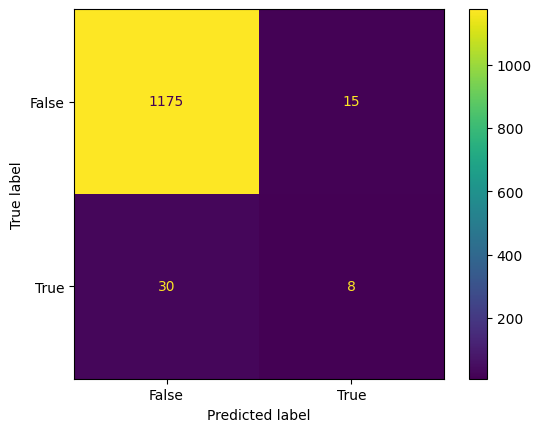

In [41]:
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax);

**Task 5.5.17** Using the model's performance on test data, generate a classification report using classification_report and store it in variable called class_report.

In [42]:
class_report = classification_report(y_test, model.predict(X_test))
print(class_report)

              precision    recall  f1-score   support

       False       0.98      0.99      0.98      1190
        True       0.35      0.21      0.26        38

    accuracy                           0.96      1228
   macro avg       0.66      0.60      0.62      1228
weighted avg       0.96      0.96      0.96      1228



# Communicate

**Task 5.5.18** Create a horizontal bar chart with the 10 most important features in the model. Add title and label your  axes. 

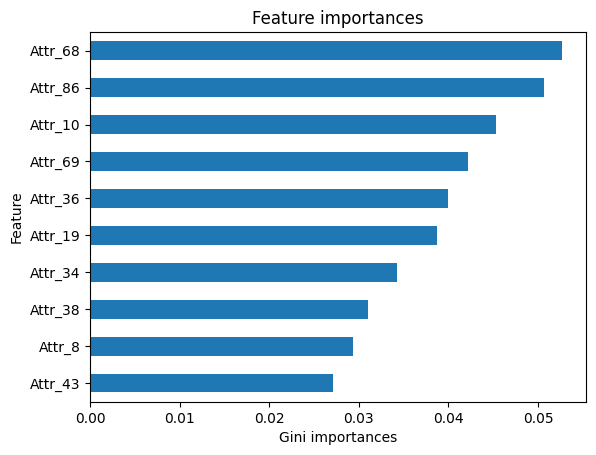

In [43]:
importances = model.best_estimator_.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values()

fig, ax = plt.subplots()
feat_imp.tail(10).plot(kind="barh",
                    xlabel="Gini importances",
                    ylabel="Feature",
                    title="Feature importances",
                    ax=ax);

**Task 5.5.19** Save your best-performing model to a file named "model-5-5.pkl"

In [44]:
# Save the model

with open("model-5-5.pkl", "wb") as f:
    pickle.dump(model, f)


**Task 5.5.20** Create a file named my_predictor_assignment.py. Add your wrangle function, and then create a make_predictions function that takes two arguments: data_filepath and model_filepath. Then use a separate cell to test your module on the test data named `taiwan-bankruptcy-data-test-features.json.gz`.

In [45]:
# Import the module
from my_predictor_assignment import make_predictions

# Generate predictions
y_test_pred = make_predictions(
    data_filepath = "data/taiwan-bankruptcy-data-test-features.json.gz",
    model_filepath = "model-5-5.pkl")

print("predictions shape:", y_test_pred.shape)
y_test_pred.head()

predictions shape: (682,)


id
10    False
13    False
40    False
41    False
71    False
Name: bankrupt, dtype: bool